<a href="https://colab.research.google.com/github/QingtaoDu/Tableau/blob/master/Final_Project_kaggle_bike_rental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Project: Kaggle Bike Rental Count Prediction**

**1. Introduction**


  In this project, we are forecasting the bike rental demand with support vector regression from sklearn. and 

Here are the attributes:

    datetime - hourly date + timestamp  
    season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
    holiday - whether the day is considered a holiday
    workingday - whether the day is neither a weekend nor holiday
    weather - 1: Clear, 2: Mist + Cloudy, 3: Light Snow, 4: Heavy Rain
    temp - temperature in Celsius
    atemp - "feels like" temperature in Celsius
    humidity - relative humidity
    windspeed - wind speed
    casual - number of non-registered user rentals initiated
    registered - number of registered user rentals initiated
    count - number of total rentals

Load all the packages required for the analysis

In [0]:
from sklearn.feature_selection import SelectPercentile, f_regression
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.decomposition import  KernelPCA
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline

**2. Data Importing & Inspecting**

Import dataset and correct datatypes

In [124]:
from google.colab import files
uploaded = files.upload()
for train in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(name=train,
                 length=len(uploaded[train])))

Saving train.csv to train (1).csv
User uploaded file "train.csv" with length 648353 bytes


In [0]:
train_df = pd.read_csv(train, parse_dates = ['datetime'])

In [126]:
uploaded = files.upload()
for test in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(name=test,
                 length=len(uploaded[test])))

Saving test.csv to test (1).csv
User uploaded file "test.csv" with length 323856 bytes


In [0]:
test_df = pd.read_csv(test, parse_dates = ['datetime'])

Exploratory Data Analysis

Get column names of the pandas data frame:

In [128]:
print(list(train_df.columns))

['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']


In [129]:
#Print the first two samples of the dataset to explore the data:
train_df.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


In [130]:
# Get data statistics for each column:
train_df[['temp', 'atemp', 'humidity', 'windspeed', 'count']].describe()

,temp,atemp,humidity,windspeed,count
count,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000
mean,20.23086,23.655084,61.886460,12.799395,191.574132
std,7.79159,8.474601,19.245033,8.164537,181.144454
min,0.82000,0.760000,0.000000,0.000000,1.000000
25%,13.94000,16.665000,47.000000,7.001500,42.000000
50%,20.50000,24.240000,62.000000,12.998000,145.000000
75%,26.24000,31.060000,77.000000,16.997900,284.000000
max,41.00000,45.455000,100.000000,56.996900,977.000000


(array([4284., 2337., 1686., 1067.,  633.,  426.,  233.,  116.,   85.,
          19.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <a list of 10 Patch objects>)

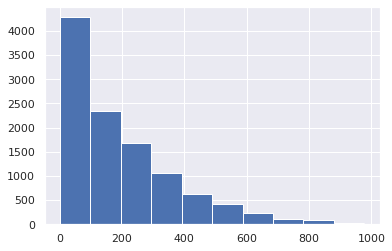

In [131]:
plt.hist(train_df["count"])

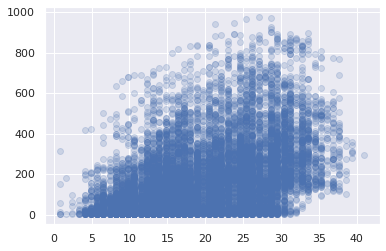

In [132]:
plt.scatter(x=train_df["temp"],y=train_df["count"],alpha=0.2,)

    The scatterplot is for temperature versus count. we can find that the bike count increases as the temperature increases.

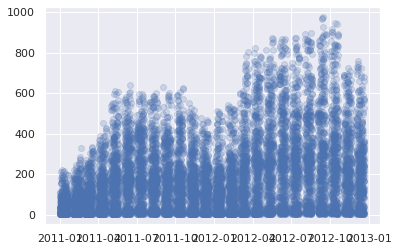

In [133]:
plt.scatter(x=train_df["datetime"],y=train_df["count"],alpha=0.2,)

    From the plot we can find that there is more counts in winter and summer, and also the counts are increasing in general.

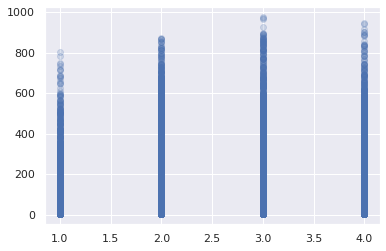

In [134]:
plt.scatter(x=train_df["season"],y=train_df["count"],alpha=0.2,)

    From the plot we can get the same conclusion of last plot.

**3 Feature Engineering and Correlation Analysis**

Check whether missing values exist.

In [135]:
train_df.isnull().any()

datetime      False
season        False
holiday       False
workingday    False
weather       False
temp          False
atemp         False
humidity      False
windspeed     False
casual        False
registered    False
count         False
dtype: bool

    No missing values exist.

In [136]:
test_df.isnull().any()

datetime      False
season        False
holiday       False
workingday    False
weather       False
temp          False
atemp         False
humidity      False
windspeed     False
dtype: bool

    No missing values exist.

Transform the 'datetime' column to 'year', 'month', 'day' and 'hour' columns.

In [0]:
## transfrom the datatime to datetime data formate
train_df["datetime"] = pd.to_datetime(train_df["datetime"])
test_df["datetime"] = pd.to_datetime(test_df["datetime"])

In [138]:
train_df["datetime"]

0       2011-01-01 00:00:00
1       2011-01-01 01:00:00
2       2011-01-01 02:00:00
3       2011-01-01 03:00:00
4       2011-01-01 04:00:00
                ...        
10881   2012-12-19 19:00:00
10882   2012-12-19 20:00:00
10883   2012-12-19 21:00:00
10884   2012-12-19 22:00:00
10885   2012-12-19 23:00:00
Name: datetime, Length: 10886, dtype: datetime64[ns]

In [0]:
def engineered_time_feature(df):
    df['year']= df.datetime.dt.year
    df['month'] = df.datetime.dt.month
    df['day_of_the_week'] = df.datetime.dt.dayofweek
    df['hour'] = df.datetime.dt.hour
    return df

In [140]:
train_df = engineered_time_feature(train_df)
test_df = engineered_time_feature(test_df)
train_df.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day_of_the_week,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,5,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,5,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,5,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,5,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,5,4


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0e0a240978>,
      dtype=object)

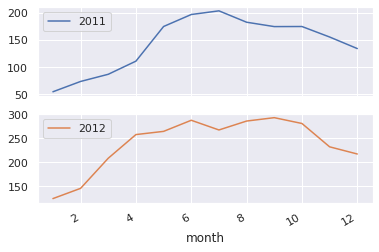

In [141]:
train_df.groupby(by=["year","month"])["count"].mean().unstack(level=0).plot(subplots=True)

Create a scatterplot of hour versus count with color scale based on temperature. First create the plot for the working days.

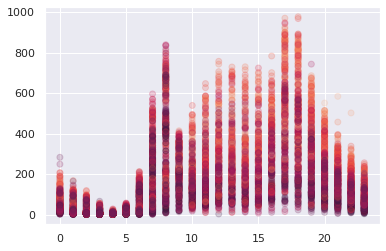

In [142]:
plt.scatter(x=train_df["hour"],y=train_df["count"],alpha=0.2,c=train_df["temp"], plotnonfinite=True)

Create the same plot for the non working days.

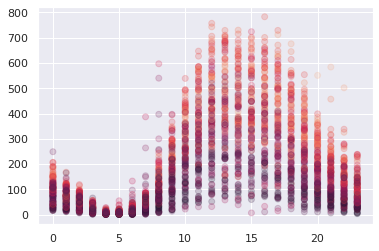

In [143]:
plt.scatter(x=train_df[train_df.workingday==0]["hour"],y=train_df[train_df.workingday==0]["count"],alpha=0.2,c=train_df[train_df.workingday==0]["temp"], plotnonfinite=True)

    From the plots we can find that the peak of bike activity is during the morning (around 8am) and right after work (around 6pm) in workingdays which is different with Nonworkingdays.

Correlation Analysis

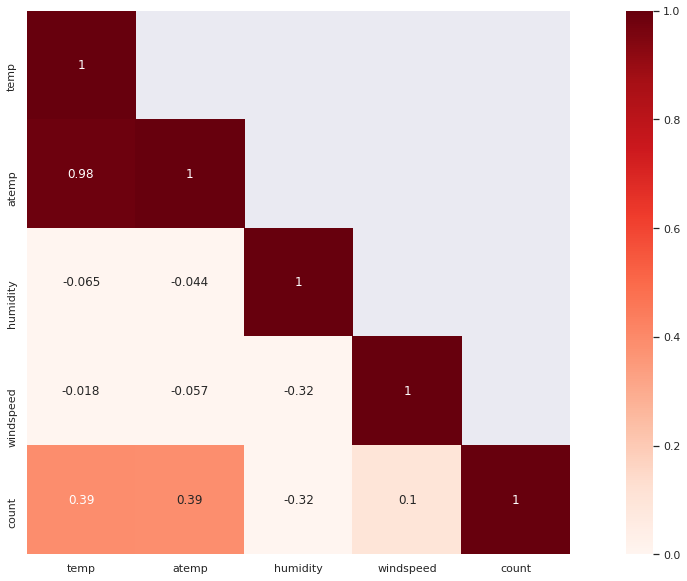

In [144]:
matrix = train_df[['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr()
heat = np.array(matrix)
heat[np.tril_indices_from(heat)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.set(font_scale=1.0)
sns.heatmap(matrix, mask=heat,vmax=1.0, vmin=0.0, square=True,annot=True, cmap="Reds")

    From Correlation Analysis we can find that "temp" and "atemp" have a strong correlation. so we only can keep one of them.

Use F test for feature selection.

In [0]:
columns = ['season', 'holiday', 'workingday', 'weather', 'temp', 'humidity', 'windspeed', 'year', 'month', 'day_of_the_week', 'hour']

In [0]:
sel_f_regression = SelectPercentile(f_regression, percentile=75).fit(train_df[columns],train_df['count'])

In [0]:
f_regression_support = sel_f_regression.get_support()

In [0]:
X_indices = np.arange(len(columns))

In [149]:
sel_f_regression.pvalues_

array([4.75893442e-066, 5.73692388e-001, 2.26448042e-001, 2.11110597e-041,
       0.00000000e+000, 2.92154166e-253, 2.89840720e-026, 3.24201724e-168,
       8.34286667e-069, 8.11715270e-001, 0.00000000e+000])

In [150]:
sel_f_regression.scores_

array([2.98716206e+02, 3.16562528e-01, 1.46319926e+00, 1.83185839e+02,
       2.00552927e+03, 1.21907840e+03, 1.13002664e+02, 7.91729803e+02,
       3.11722553e+02, 5.67485718e-02, 2.08057151e+03])

<BarContainer object of 11 artists>

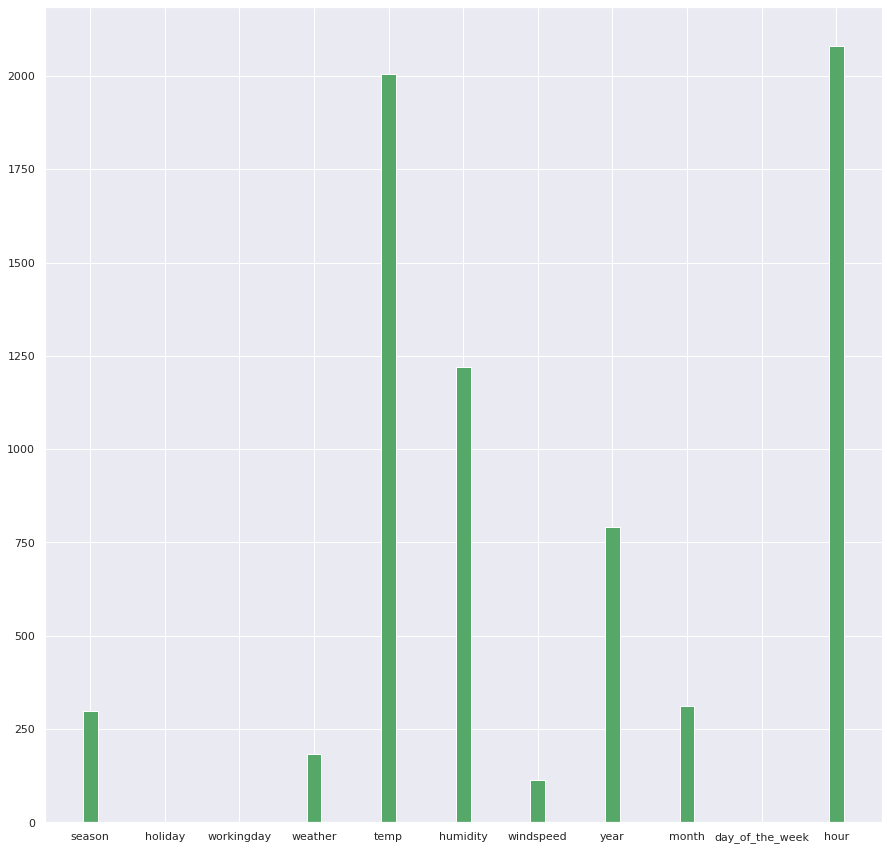

In [151]:
scores = sel_f_regression.scores_
plt.figure(figsize= (15, 15))
plt.bar(columns, scores, width=.2,
        label=r'core ($-Log(p_{value})$)', color='g')

    From the plot we can find the F test can capture the linear relationship between target and features. 'temp' and 'count' are the highest correlated features.

Use mutual_info_regression in SelectPercentile(percentile=75) to plot the scores.

<BarContainer object of 11 artists>

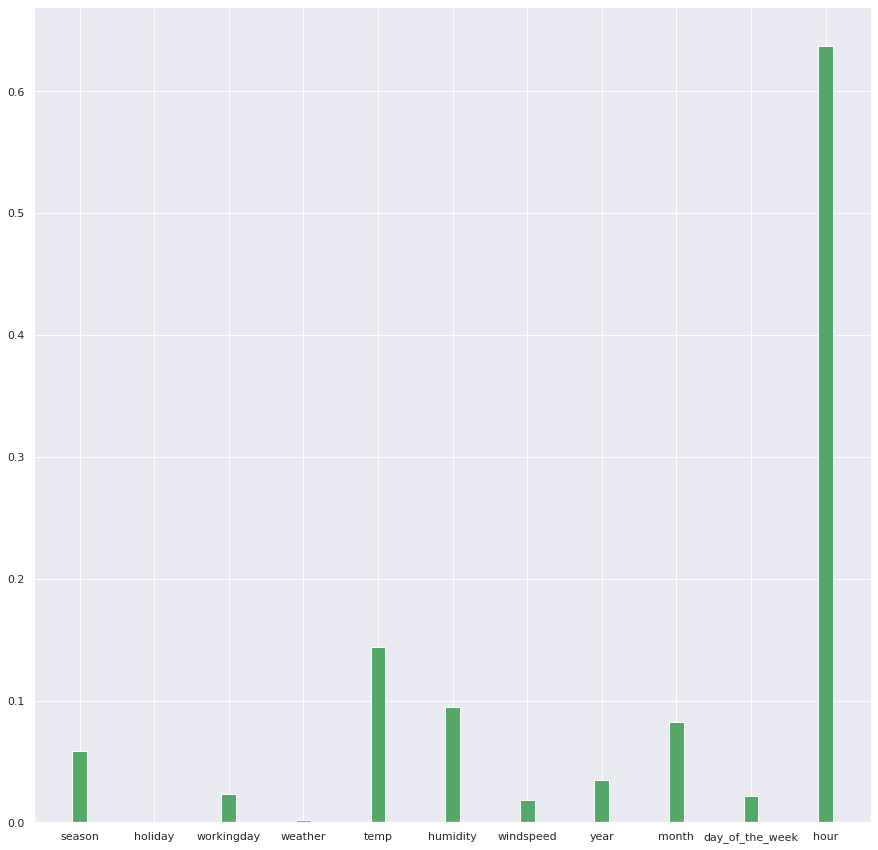

In [152]:
mu_info_regression = SelectPercentile(mutual_info_regression, percentile=75).fit(train_df[columns],train_df['count'])
scores = mu_info_regression.scores_
plt.figure(figsize= (15, 15))
plt.bar(columns, scores, width=.2,
        label=r'core ($-Log(p_{value})$)', color='g')

    From the plot we can find that mutual_info_regression can capture the nonlinear information. So, we will use it for feature selection

**4 Prediction**

In [0]:
# Build FeatureUnion and use KernelPCA for transformer_list
parallel = FeatureUnion(transformer_list=[('kpca', KernelPCA())])

# Use SVR(support vector regression) from sklearn.svm as a regressor(to predict count).
regre = SVR()

# Use SelectPercentile and mutual_info_regression as a feature selector.
sel = SelectPercentile(mutual_info_regression, percentile=75)

# Build the Pipeline
pipeline = Pipeline(steps = [('parallel_transform', parallel), ('select',sel), ('reg',regre)])

# Use grid search 
hyper_param = [{'reg__C':[1, 2, 4, 6], 'reg__gamma': [0.008, 0.08, 0.16, 0.32, 0.5]}]
search_clf = GridSearchCV(estimator=pipeline, param_grid=hyper_param, cv = 4,n_jobs=-1)

In [0]:
# fit on train_df
search_clf.fit(train_df[columns], train_df['count'])

In [0]:
# Use trained regressor on test_df to predict count
X_test = test_df.drop('datetime', axis =1)
X_test['count']= search_clf.predict(X_test)
X_test['count'] = X_test['count'].map(lambda x: x if x >0 else 0)
test_df["count"] = X_test['count']
test_df[["datetime","count"]].to_csv("test_pred.csv",index=False)

**5 Conclusion**

in the project I procticeed the support vector regression, F test for feature selection, Pipeline and grid search to the Predictions of bike rental dataset.
and I am eager to learn more and develop skills on machine learning.